In [241]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [242]:
df=pd.read_csv('./HINDUNILVR.csv',index_col='Date',parse_dates=True)

Data Pre processing


In [243]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,HINDLEVER,EQ,2136.60,2300.0,2307.55,2300.00,2307.55,2307.55,2307.08,24903,5.745330e+12,NaN,NaN,NaN
2000-01-04,HINDLEVER,EQ,2307.55,2381.0,2381.00,2250.00,2270.00,2281.05,2298.15,58514,1.344740e+13,NaN,NaN,NaN
2000-01-05,HINDLEVER,EQ,2281.05,2200.0,2250.00,2105.00,2183.50,2199.90,2211.17,80296,1.775482e+13,NaN,NaN,NaN
2000-01-06,HINDLEVER,EQ,2199.90,2224.9,2360.00,2210.00,2300.00,2288.20,2301.80,190032,4.374157e+13,NaN,NaN,NaN
2000-01-07,HINDLEVER,EQ,2288.20,2300.0,2452.00,2282.25,2395.00,2412.95,2380.24,192582,4.583919e+13,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,HINDUNILVR,EQ,2307.75,2324.0,2369.80,2311.00,2367.70,2360.65,2340.89,1946867,4.557405e+14,85684.0,1289103.0,0.6621
2021-04-27,HINDUNILVR,EQ,2360.65,2363.0,2386.45,2352.95,2378.00,2379.85,2374.40,1668456,3.961583e+14,84641.0,1089882.0,0.6532
2021-04-28,HINDUNILVR,EQ,2379.85,2380.0,2445.00,2366.30,2404.00,2406.55,2414.15,1951215,4.710522e+14,84910.0,1024216.0,0.5249


In [244]:
df['Date']=df.index

In [245]:
start_date='2020-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [246]:
df=df.loc[mask]

In [247]:
df=df.loc[mask]

In [248]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [249]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [250]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [251]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [252]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (201, 50) Y.shape (201,)


In [253]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

ANN

In [254]:
i=Input(shape=(T,))
x=Dense(400,activation='relu')(i)
x=Dense(100,activation='relu')(x)
x=Dense(50,activation='relu')(x)
x=Dense(1,activation='relu')(x)
model_ann=Model(i,x)
model_ann.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 50)]              0         
                                                                 
 dense_44 (Dense)            (None, 400)               20400     
                                                                 
 dense_45 (Dense)            (None, 100)               40100     
                                                                 
 dense_46 (Dense)            (None, 50)                5050      
                                                                 
 dense_47 (Dense)            (None, 1)                 51        
                                                                 
Total params: 65,601
Trainable params: 65,601
Non-trainable params: 0
_________________________________________________________________


In [255]:
model_ann.compile(
    loss='mse',
    optimizer='adamax',
    metrics='mae'
)

In [256]:
r=model_ann.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest)
)

Epoch 1/100
4/4 [==============================] - 0s 52ms/step - loss: 3196.8333 - mae: 37.7820 - val_loss: 757.8262 - val_mae: 21.5363
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 2708.4822 - mae: 34.3125 - val_loss: 768.1317 - val_mae: 21.6140
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 2496.0864 - mae: 32.7358 - val_loss: 781.3102 - val_mae: 21.9185
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 2419.9390 - mae: 32.0536 - val_loss: 794.6372 - val_mae: 22.1860
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 2309.4468 - mae: 31.1793 - val_loss: 802.5897 - val_mae: 22.2677
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 2257.1411 - mae: 30.4822 - val_loss: 812.0876 - val_mae: 22.3907
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 2211.8525 - mae: 30.2906 - val_loss: 824.3580 - val_mae: 22.6315
Epoch 8/100
4/4 [==========================

CNN

In [257]:
i=Input(shape=(T,1))
x=Conv1D(25,3,activation='relu')(i)
x=MaxPooling1D(2)(x)
x=Conv1D(50,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(1)(x)
model_cnn=Model(i,x)
model_cnn.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 48, 25)            100       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 24, 25)           0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 22, 50)            3800      
                                                                 
 global_max_pooling1d_12 (Gl  (None, 50)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_48 (Dense)            (None, 1)                 51 

In [258]:
model_cnn.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [259]:
r=model_cnn.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest)
)

Epoch 1/100
4/4 [==============================] - 1s 50ms/step - loss: 5084.3643 - mae: 45.4202 - mse: 5084.3643 - val_loss: 801.1575 - val_mae: 21.8994 - val_mse: 801.1575
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 3682.2644 - mae: 37.6819 - mse: 3682.2644 - val_loss: 741.2040 - val_mae: 21.2721 - val_mse: 741.2040
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 3543.5886 - mae: 40.1356 - mse: 3543.5886 - val_loss: 744.1331 - val_mae: 21.4697 - val_mse: 744.1331
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 3585.4663 - mae: 41.5093 - mse: 3585.4663 - val_loss: 744.9165 - val_mae: 21.5025 - val_mse: 744.9165
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 3510.4497 - mae: 40.7121 - mse: 3510.4497 - val_loss: 740.1294 - val_mae: 21.3840 - val_mse: 740.1294
Epoch 6/100
4/4 [==============================] - 0s 16ms/step - loss: 3416.3611 - mae: 39.3636 - mse: 3416.3611 - val_loss: 738.

LSTM

In [260]:
i=Input(shape=(T,1))
x=LSTM(200,return_sequences=True)(i)
x=LSTM(200,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_lstm=Model(i,x)
model_lstm.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 lstm_8 (LSTM)               (None, 50, 200)           161600    
                                                                 
 lstm_9 (LSTM)               (None, 50, 200)           320800    
                                                                 
 global_max_pooling1d_13 (Gl  (None, 200)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_49 (Dense)            (None, 100)               20100     
                                                                 
 dense_50 (Dense)            (None, 50)                5050      
                                                          

In [261]:
check_point_lstm=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [262]:
model_lstm.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [263]:
r=model_lstm.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_lstm]
)

Epoch 1/100
4/4 [==============================] - 4s 422ms/step - loss: 3217.3467 - mae: 36.7564 - mse: 3217.3467 - val_loss: 750.5675 - val_mae: 21.2200 - val_mse: 750.5675
Epoch 2/100
4/4 [==============================] - 1s 198ms/step - loss: 3210.1460 - mae: 36.7317 - mse: 3210.1460 - val_loss: 746.7008 - val_mae: 21.1908 - val_mse: 746.7008
Epoch 3/100
4/4 [==============================] - 1s 189ms/step - loss: 3206.6313 - mae: 36.7193 - mse: 3206.6313 - val_loss: 747.9383 - val_mae: 21.1976 - val_mse: 747.9383
Epoch 4/100
4/4 [==============================] - 1s 184ms/step - loss: 3206.0034 - mae: 36.7489 - mse: 3206.0034 - val_loss: 746.7232 - val_mae: 21.1913 - val_mse: 746.7232
Epoch 5/100
4/4 [==============================] - 1s 195ms/step - loss: 3203.6509 - mae: 36.7260 - mse: 3203.6509 - val_loss: 747.1231 - val_mae: 21.1928 - val_mse: 747.1231
Epoch 6/100
4/4 [==============================] - 1s 194ms/step - loss: 3200.5632 - mae: 36.6996 - mse: 3200.5632 - val_loss

GRU

In [264]:
i=Input(shape=(T,1))
x=GRU(200,return_sequences=True)(i)
x=GRU(200,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_gru=Model(i,x)
model_gru.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fe98cab1890>>

In [265]:
check_point_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [266]:
model_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [267]:
r=model_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_gru]
)

Epoch 1/100
4/4 [==============================] - 5s 374ms/step - loss: 3234.1729 - mae: 36.7003 - mse: 3234.1729 - val_loss: 754.9891 - val_mae: 21.2541 - val_mse: 754.9891
Epoch 2/100
4/4 [==============================] - 1s 182ms/step - loss: 3214.8813 - mae: 36.8933 - mse: 3214.8816 - val_loss: 740.0187 - val_mae: 21.1385 - val_mse: 740.0187
Epoch 3/100
4/4 [==============================] - 1s 167ms/step - loss: 3203.5881 - mae: 36.9031 - mse: 3203.5881 - val_loss: 743.9473 - val_mae: 21.1492 - val_mse: 743.9473
Epoch 4/100
4/4 [==============================] - 1s 168ms/step - loss: 3202.0857 - mae: 36.8457 - mse: 3202.0857 - val_loss: 743.7074 - val_mae: 21.1393 - val_mse: 743.7074
Epoch 5/100
4/4 [==============================] - 1s 170ms/step - loss: 3197.3064 - mae: 36.7221 - mse: 3197.3064 - val_loss: 746.2303 - val_mae: 21.1519 - val_mse: 746.2303
Epoch 6/100
4/4 [==============================] - 1s 168ms/step - loss: 3191.5789 - mae: 36.5996 - mse: 3191.5789 - val_loss

Predictions

In [268]:
train_idx[:T+1]=False

In [269]:
Ptrain_ann=model_ann.predict(Xtrain).flatten()
Ptest_ann=model_ann.predict(Xtest).flatten()


In [270]:
Ptrain_cnn=model_cnn.predict(Xtrain).flatten()
Ptest_cnn=model_cnn.predict(Xtest).flatten()

In [271]:
Ptrain_lstm=model_lstm.predict(Xtrain).flatten()
Ptest_lstm=model_lstm.predict(Xtest).flatten()

In [272]:
Ptrain_gru=model_gru.predict(Xtrain).flatten()
Ptest_gru=model_gru.predict(Xtest).flatten()

In [273]:
df.loc[train_idx,'Diff ANN train prediction']=Ptrain_ann
df.loc[test_idx,'Diff ANN test prediction']=Ptest_ann

In [274]:
df.loc[train_idx,'Diff CNN train prediction']=Ptrain_cnn
df.loc[test_idx,'Diff CNN test prediction']=Ptest_cnn

In [275]:
df.loc[train_idx,'Diff LSTM train prediction']=Ptrain_lstm
df.loc[test_idx,'Diff LSTM test prediction']=Ptest_lstm

In [276]:
df.loc[train_idx,'Diff GRU train prediction']=Ptrain_gru
df.loc[test_idx,'Diff GRU test prediction']=Ptest_gru

In [277]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [278]:
last_train=train.iloc[-1]['Prev Close']

In [279]:
df.loc[train_idx,'train_ANN']=prev[train_idx]+Ptrain_ann
df.loc[test_idx,'Prediction_ANN']=prev[test_idx]+Ptest_ann

In [280]:
df.loc[train_idx,'train_CNN']=prev[train_idx]+Ptrain_cnn
df.loc[test_idx,'Prediction_CNN']=prev[test_idx]+Ptest_cnn

In [281]:
df.loc[train_idx,'train_LSTM']=prev[train_idx]+Ptrain_lstm
df.loc[test_idx,'Prediction_LSTM']=prev[test_idx]+Ptest_lstm

In [282]:
df.loc[train_idx,'train_GRU']=prev[train_idx]+Ptrain_gru
df.loc[test_idx,'Prediction_GRU']=prev[test_idx]+Ptest_gru

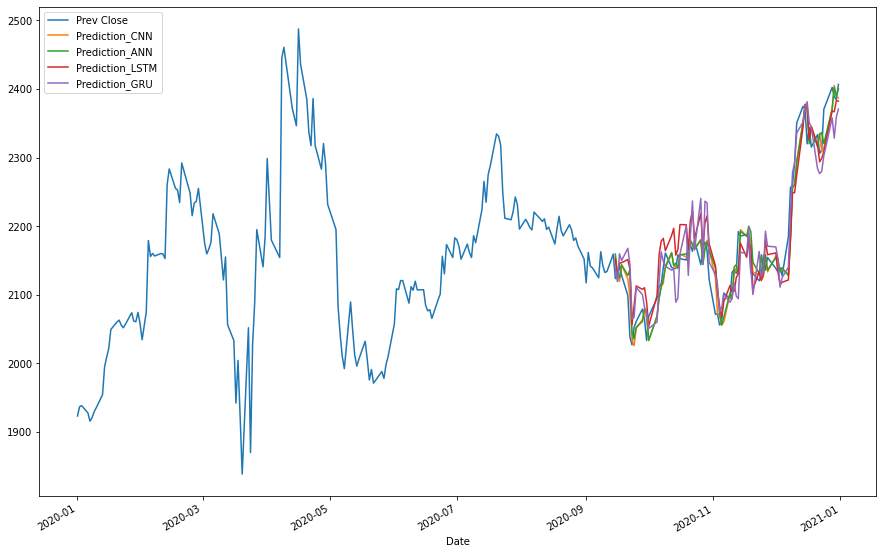

In [283]:
df[[ 'Prev Close','Prediction_CNN','Prediction_ANN','Prediction_LSTM','Prediction_GRU']].plot(figsize=(15,10));

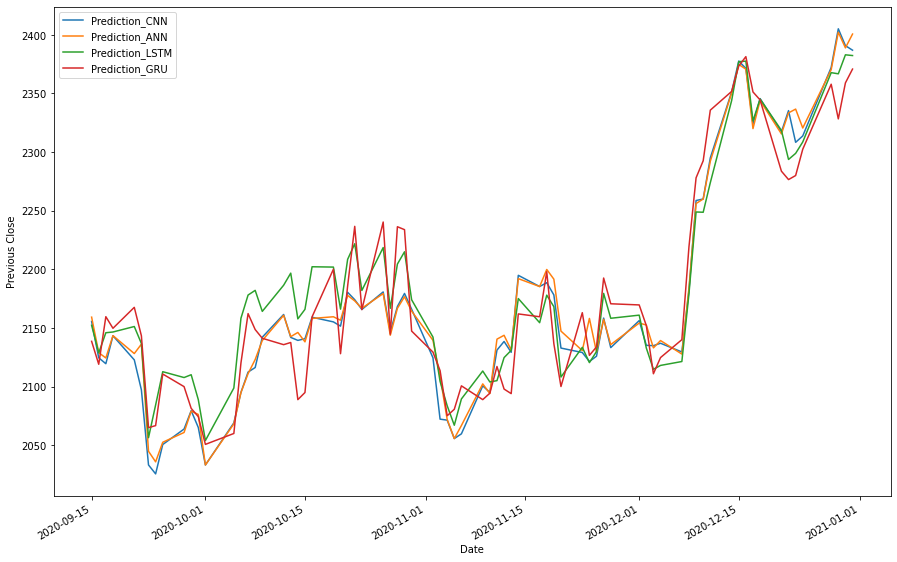

In [284]:
df[[ 'Prediction_CNN','Prediction_ANN','Prediction_LSTM','Prediction_GRU']].plot(figsize=(15,10),
    ylabel=("Previous Close"));

Evaluation

In [285]:
pred_ann=df['Prediction_ANN']
pred_ann.dropna(inplace=True)

In [286]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_ann))
print(rmse)

30.02548894762925


In [287]:
error=mean_absolute_error(test['Prev Close'],pred_ann)
print(error)

23.549727298577604


In [288]:
r2_score(test['Prev Close'],pred_ann)

0.9092282267320517

In [289]:
pred_cnn=df['Prediction_CNN']
pred_cnn.dropna(inplace=True)

In [290]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_cnn))
print(rmse)

27.232616999008336


In [291]:
error=mean_absolute_error(test['Prev Close'],pred_cnn)
print(error)

21.085239767764985


In [292]:
r2_score(test['Prev Close'],pred_cnn)

0.9253294415682501

In [293]:
pred_lstm=df['Prediction_LSTM']
pred_lstm.dropna(inplace=True)

In [294]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_lstm))
print(rmse)

38.34209915454674


In [295]:
error=mean_absolute_error(test['Prev Close'],pred_lstm)
print(error)

30.958150468031544


In [296]:
r2_score(test['Prev Close'],pred_lstm)

0.8519793132327287

In [297]:
pred_gru=df['Prediction_GRU']
pred_gru.dropna(inplace=True)

In [298]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_gru))
print(rmse)

39.74738253744744


In [299]:
error=mean_absolute_error(test['Prev Close'],pred_gru)
print(error)

31.957666619141886


In [300]:
r2_score(test['Prev Close'],pred_gru)

0.840930208401323